Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total data: 1601
Kolom: ['intent_id', 'role', 'intent_name', 'desc', 'utterence', 'entity']
Contoh data setelah preprocessing:
    role                                          utterence  \
0   guru  Kak, cekin murid Karin Widya tahun ajaran 2021...   
1  murid  data kehadiran ak nama Rangga Pratama di thn a...   
2  admin               Taufik Hidayat 05/12/2024 absen gak?   
3  admin  Pak, tolong upload status kehadiran Andi Nugro...   
4  murid  Min, aku mau cek nilai satu-satu, bisa bukain ...   

                                          clean_text  \
0  [ROLE:guru] kak cekin murid karin widya tahun ...   
1  [ROLE:murid] data kehadiran ak nama rangga pra...   
2     [ROLE:admin] taufik hidayat 05122024 absen gak   
3  [ROLE:admin] pak tolong upload status kehadira...   
4  [ROLE:murid] min aku mau cek nilai satusatu bi...   

                         int

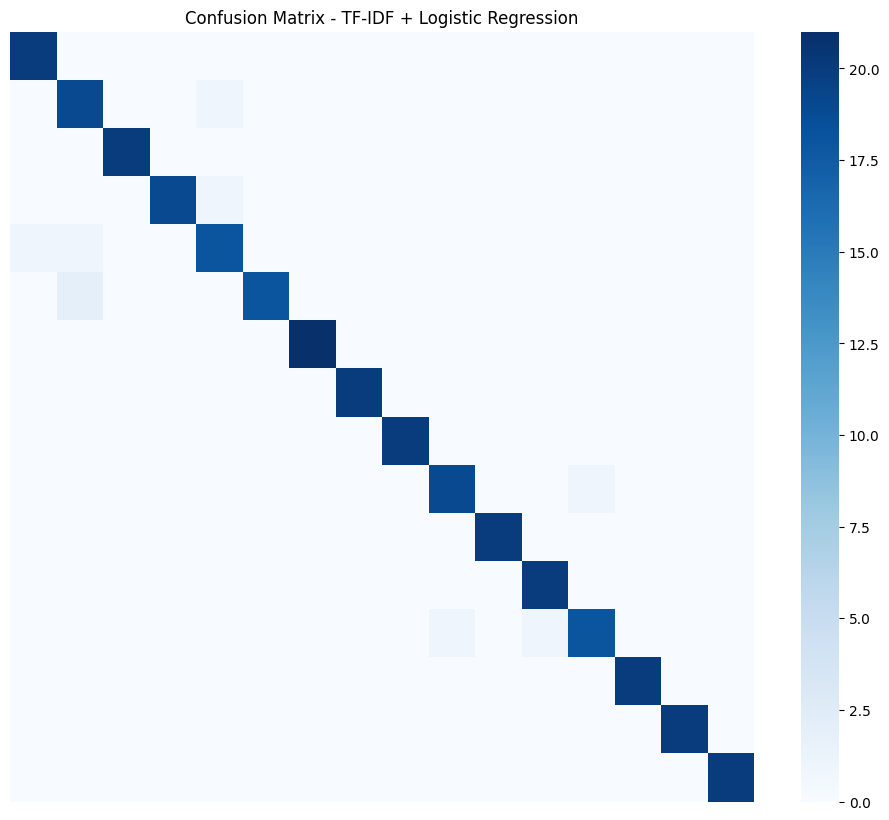

✅ Model disimpan di /content/drive/My Drive/Colab Notebooks/Uchat/Model/FM TF-IDF/fm_intent_classifier_tfidf_lr.pkl


In [3]:
# ================================================================
# 1️⃣ Mount Google Drive
# ================================================================
from google.colab import drive
drive.mount('/content/drive')

# ================================================================
# 2️⃣ Load Dataset
# ================================================================
import pandas as pd

data_path = "/content/drive/My Drive/Colab Notebooks/Uchat/Dataset/dataset_focus_mode.csv"
df = pd.read_csv(data_path)

print("Total data:", len(df))
print("Kolom:", list(df.columns))
df.head(10)

# ================================================================
# 3️⃣ Preprocessing — Menyamakan Format Dengan IndoBERT
# ================================================================
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9à-ž\s]', '', text)  # hapus simbol
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Format baru: [ROLE:ADMIN] <utterance>
df["clean_text"] = df.apply(
    lambda r: f"[ROLE:{r['role']}] {clean_text(r['utterence'])}",
    axis=1
)

df["intent"] = df["intent_name"]

print("Contoh data setelah preprocessing:")
print(df[["role", "utterence", "clean_text", "intent"]].head())

# ================================================================
# 4️⃣ Stratified Split (sama seperti BERT)
# ================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["intent"],
    test_size=0.2,
    random_state=42,
    stratify=df["intent"]
)

print("Data train:", len(X_train))
print("Data test:", len(X_test))

# ================================================================
# 5️⃣ TF-IDF Vectorization + Logistic Regression Classifier
# ================================================================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Pipeline identik dengan baseline umum NLP
model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=-1, C=2.0))
])

print("\nTraining model...")
model.fit(X_train, y_train)
print("✅ Training selesai!")

# ================================================================
# 6️⃣ Evaluasi Model (sama seperti IndoBERTweet)
# ================================================================
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=2))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()

# ================================================================
# 7️⃣ Simpan Model (opsional)
# ================================================================
import joblib

save_path = "/content/drive/My Drive/Colab Notebooks/Uchat/Model/FM TF-IDF"
joblib.dump(model, f"{save_path}/fm_intent_classifier_tfidf_lr.pkl")

print(f"✅ Model disimpan di {save_path}/fm_intent_classifier_tfidf_lr.pkl")


In [4]:
def predict_intent(text):
    cleaned = clean_text(text)
    pred = model.predict([cleaned])[0]
    prob = model.predict_proba([cleaned]).max()
    return pred, prob

sample_utterances = [
    ("[ROLE:guru]", "lihat jadwal saya untuk besok"),
    ("[ROLE:ortu]", "Saya ingin cek nilai anak saya"),
    ("[ROLE:murid]", "Saya ingin cek prestasi saya Rio Liando"),
    ("[ROLE:admin]", "Redirect ke halaman pengaturan dong")
]

for utt in sample_utterances:
    intent, conf = predict_intent(utt)
    print(f"🗣️ '{utt}' → 🎯 {intent} (confidence={conf:.2f})")

🗣️ '('[ROLE:guru]', 'lihat jadwal saya untuk besok')' → 🎯 teacher_schedule_view (confidence=0.16)
🗣️ '('[ROLE:ortu]', 'Saya ingin cek nilai anak saya')' → 🎯 student_scores_view (confidence=0.25)
🗣️ '('[ROLE:murid]', 'Saya ingin cek prestasi saya Rio Liando')' → 🎯 student_achivement (confidence=0.28)
🗣️ '('[ROLE:admin]', 'Redirect ke halaman pengaturan dong')' → 🎯 teacher_score_view (confidence=0.20)
